***USED FOR ANALYSIS OF TRANSCRIPTION***

**TO DO** 

- Remove filler words and do csv analysis.
- Find which words come in as replacement and make graphs
- What to do with gaap and EBITDA

In [1]:
import os
from jiwer import wer, mer, wil, compute_measures
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
from rapidfuzz import fuzz, process
import warnings
from pathlib import Path
from matplotlib.patches import Patch
from difflib import SequenceMatcher
import unicodedata

from scipy.stats import f_oneway

In [2]:
def is_latin_char(ch): # Check if a character is Latin or a digit to avoid foreign
    name = unicodedata.name(ch, '')
    return 'LATIN' in name or ch.isdigit() or ch.isspace() or ch in "_"

def clean_and_tokenize(text):
    text = text.lower()
    # Remove possessive 's after numbers like 2021's → 2021
    text = re.sub(r"(?<=\d)'s\b", "", text)
    #Replace - with space
    text = text.replace('-', ' ')
    # Protect decimals (e.g. 2.4 → 2__DOT__4)
    text = re.sub(r'(?<=\d)\.(?=\d)', '__DOT__', text)
    text = ''.join(ch for ch in text if is_latin_char(ch))
    # Restore decimals
    text = text.replace('__DOT__', '.')

    return text.split()

def read_txt_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().strip()

def get_transcript_variants(root_folder, suffixes):
    all_pairs = []
    for subdir in os.listdir(root_folder):
        full_path = os.path.join(root_folder, subdir)
        if os.path.isdir(full_path):
            files = os.listdir(full_path)
            gt_file = [f for f in files if f.endswith('.txt') and not any(f.endswith(suffix) for suffix in suffixes) and not f.endswith('_timing.txt')]
            if not gt_file:
                continue
            gt_path = os.path.join(full_path, gt_file[0])
            for suffix in suffixes:
                hyp_file = [f for f in files if f == f"{subdir}{suffix}"]
                if hyp_file:
                    hyp_path = os.path.join(full_path, hyp_file[0])
                    all_pairs.append((subdir, suffix, gt_path, hyp_path))
    return all_pairs

def compute_metrics(gt_text, hyp_text):
    measures = compute_measures(gt_text, hyp_text)
    return {
        "wer": measures['wer'],
        "mer": measures['mer'],
        "wil": measures['wil']
    }

def evaluate_folder_variants(base_folder, suffixes):
    results = []
    rows = []
    pairs = get_transcript_variants(base_folder, suffixes)

    for folder_name, suffix, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        gt_tokens = clean_and_tokenize(gt)
        hyp_tokens = clean_and_tokenize(hyp)
        gt_clean = ' '.join(gt_tokens)
        hyp_clean = ' '.join(hyp_tokens)
        metrics = compute_metrics(gt_clean, hyp_clean)

        results.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "gt_path": gt_path,
            "hyp_path": hyp_path,
            "gt_text": gt_clean,
            "hyp_text": hyp_clean,
            "gt_word_count": len(gt_tokens),
            "hyp_word_count": len(hyp_tokens)
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)

    # Total word count printout
    summary = df_paths.groupby("variant")[["gt_word_count", "hyp_word_count"]].sum()
    print(f"\n{base_folder} — Total word counts:")
    print(summary)

    return df_metrics, df_paths


variant_name_map = {
    '_Whisper.txt': 'whisper-small',
    '_Turbo_Whisper.txt': 'whisper-large-v3-turbo',
    '_openai_transcript.txt': 'GPT-4o mini Transcribe'
}

suffixes = ['_Whisper.txt', '_openai_transcript.txt', '_Turbo_Whisper.txt']
df_21, df_paths_21 = evaluate_folder_variants('Data/combined_21', suffixes)
print("Combined 21 summary:")
print(df_21.groupby("variant").describe())

df_22, df_paths_22 = evaluate_folder_variants('Data/combined_22', suffixes)
print("\nCombined 22 summary:")
print(df_22.groupby("variant").describe())


Data/combined_21 — Total word counts:
                        gt_word_count  hyp_word_count
variant                                              
GPT-4o mini Transcribe         364074          338038
whisper-large-v3-turbo         364074          345377
whisper-small                  364074          345946
Combined 21 summary:
                         wer                                          \
                       count      mean       std       min       25%   
variant                                                                
GPT-4o mini Transcribe  44.0  0.130032  0.041143  0.066328  0.101971   
whisper-large-v3-turbo  44.0  0.130932  0.041245  0.059085  0.105611   
whisper-small           44.0  0.158218  0.045551  0.103009  0.129052   

                                                       mer            ...  \
                             50%       75%       max count      mean  ...   
variant                                                               ...   
GPT-4o

In [3]:
percent_per_variant = (
    df_22.assign(over_50=df_22['wer'] > 0.4)
         .groupby("variant")['over_50']
         .mean() * 100
)

print("Percentage of files with WER > 40%:")
print(percent_per_variant.round(1))


Percentage of files with WER > 40%:
variant
GPT-4o mini Transcribe    4.0
whisper-large-v3-turbo    1.6
whisper-small             3.2
Name: over_50, dtype: float64


In [4]:
# Step 1: Combine all metrics and paths
df_all = pd.concat([df_21, df_22], ignore_index=True)
df_paths_all = pd.concat([df_paths_21, df_paths_22], ignore_index=True)
df_full = pd.merge(df_all, df_paths_all, on=['folder', 'variant'], how='left')

# Step 2: Compute average WER per folder
avg_wer_per_folder = (
    df_full.groupby("folder")['wer']
    .mean()
    .reset_index(name='avg_wer')
)

# Step 3: Get top 3 folders with highest average WER
top_3_folders = avg_wer_per_folder.nlargest(3, 'avg_wer')['folder'].tolist()

# Step 4: Get all rows for those top 3 folders
top_3_details = df_full[df_full['folder'].isin(top_3_folders)]

# Step 5: Print nicely
print("Top 3 folders with highest average WER across variants:\n")
for folder in top_3_folders:
    folder_df = top_3_details[top_3_details['folder'] == folder]
    avg = folder_df['wer'].mean()
    print(f"Folder: {folder} (Avg WER: {avg:.2f})")
    for _, row in folder_df.iterrows():
        print(f"  Variant: {row['variant']}")
        print(f"    WER: {row['wer']:.2f}")
        print(f"    GT Path: {row['gt_path']}")
        print(f"    Hyp Path: {row['hyp_path']}")
    print()


Top 3 folders with highest average WER across variants:

Folder: 4453076 (Avg WER: 0.73)
  Variant: whisper-small
    WER: 0.77
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_Whisper.txt
  Variant: GPT-4o mini Transcribe
    WER: 0.73
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_openai_transcript.txt
  Variant: whisper-large-v3-turbo
    WER: 0.69
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_Turbo_Whisper.txt

Folder: 4481766 (Avg WER: 0.50)
  Variant: whisper-small
    WER: 0.61
    GT Path: Data/combined_22\4481766\4481766.txt
    Hyp Path: Data/combined_22\4481766\4481766_Whisper.txt
  Variant: GPT-4o mini Transcribe
    WER: 0.41
    GT Path: Data/combined_22\4481766\4481766.txt
    Hyp Path: Data/combined_22\4481766\4481766_openai_transcript.txt
  Variant: whisper-large-v3-turbo
    WER: 0.47
    GT Path: Data/combined_22\4481766


=== WER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WER: 0.130
GPT-4o mini Transcribe         | Earnings22   → Mean WER: 0.181
whisper-large-v3-turbo         | Earnings21   → Mean WER: 0.131
whisper-large-v3-turbo         | Earnings22   → Mean WER: 0.186
whisper-small                  | Earnings21   → Mean WER: 0.158
whisper-small                  | Earnings22   → Mean WER: 0.219

=== MER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean MER: 0.128
GPT-4o mini Transcribe         | Earnings22   → Mean MER: 0.177
whisper-large-v3-turbo         | Earnings21   → Mean MER: 0.128
whisper-large-v3-turbo         | Earnings22   → Mean MER: 0.178
whisper-small                  | Earnings21   → Mean MER: 0.154
whisper-small                  | Earnings22   → Mean MER: 0.206

=== WIL Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WIL: 0.166
GPT-4o mini Transcribe         | Earnings22  

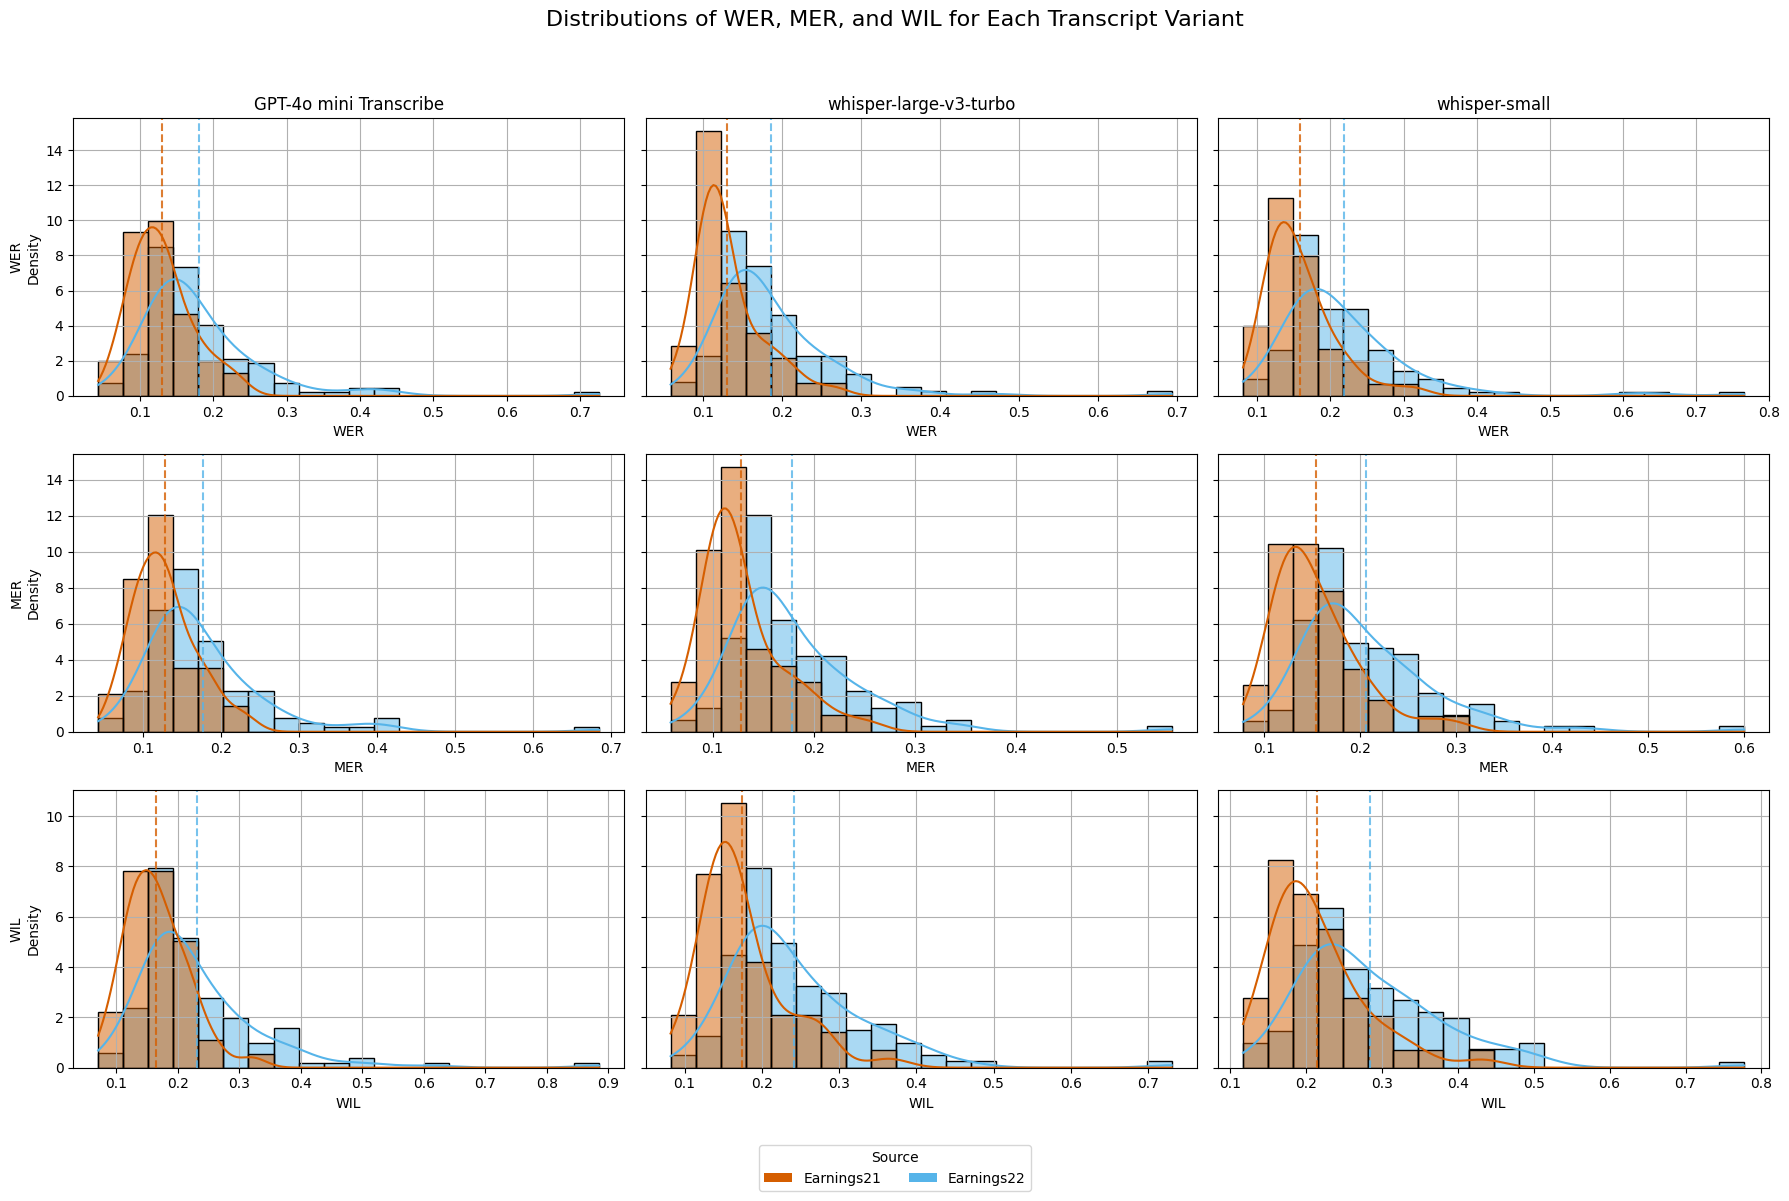

In [5]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# Add 'source' column and combine
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'
df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Melt for boxplot
df_melted = df_combined.melt(
    id_vars=['folder', 'source', 'variant'],
    value_vars=['wer', 'mer', 'wil'],
    var_name='metric',
    value_name='value'
)

palette = {
    "combined_21": "#D55E00",
    "combined_22": "#56B4E9"
}

legend_label_map = {
    "combined_21": "Earnings21",
    "combined_22": "Earnings22"
}

variants = sorted(df_combined['variant'].unique())
metrics = ['wer', 'mer', 'wil']

# === Combined 3x3 figure ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey='row')

for row, metric in enumerate(metrics):
    print(f"\n=== {metric.upper()} Means by Variant and Source ===")

    for col, variant in enumerate(variants):
        ax = axes[row][col]
        df_variant = df_combined[df_combined['variant'] == variant]

        # Histogram with KDE
        sns.histplot(
            data=df_variant,
            x=metric,
            hue='source',
            palette=palette,
            kde=True,
            bins=20,
            stat='density',
            common_norm=False,
            ax=ax,
            legend=False
        )

        # Add vertical mean lines and print
        for source in df_variant['source'].unique():
            source_df = df_variant[df_variant['source'] == source]
            mean_val = source_df[metric].mean()
            color = palette[source]

            # Print to console
            print(f"{variant:30} | {legend_label_map[source]:12} → Mean {metric.upper()}: {mean_val:.3f}")

            ax.axvline(mean_val, linestyle='--', color=color, linewidth=1.5, alpha=0.8)

        # Titles and labels
        if row == 0:
            ax.set_title(f"{variant}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{metric.upper()}\nDensity", fontsize=10)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(metric.upper())
        ax.grid(True)

# === Add shared legend with renamed labels ===
legend_elements = [
    Patch(facecolor=palette["combined_21"], label="Earnings21"),
    Patch(facecolor=palette["combined_22"], label="Earnings22")
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.01),
    frameon=True,
    title="Source"
)

fig.suptitle("Distributions of WER, MER, and WIL for Each Transcript Variant", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


I want to find filler words that are only in the ground truth but not the transcripts


C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

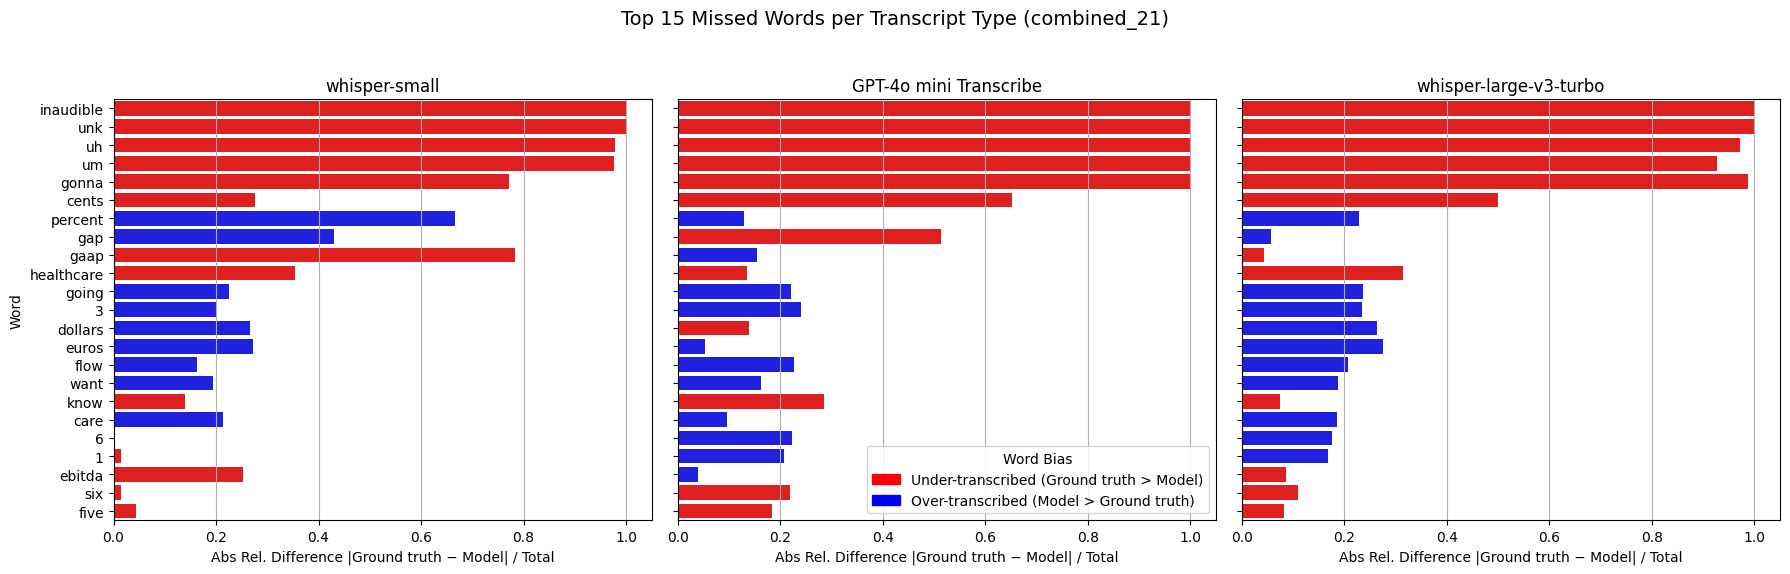

C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

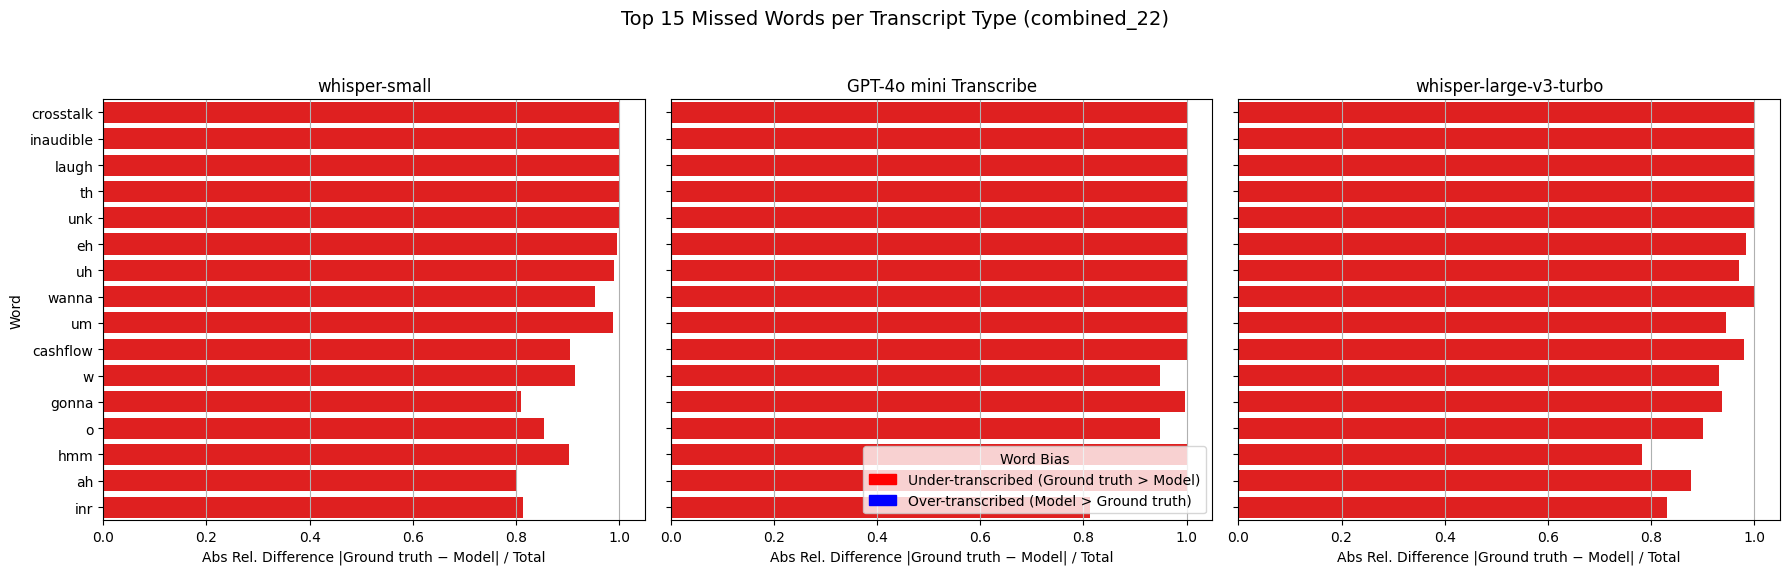

In [6]:
min_total = 100
def get_top_missed_words_by_variant(df_paths, label='', top_n=15, plot=True, filter_words=None):
    variants = df_paths['variant'].unique()
    fig, axes = plt.subplots(1, len(variants), figsize=(6 * len(variants), 6), sharey=True) if plot else (None, [None] * len(variants))
    if len(variants) == 1:
        axes = [axes]  

    all_top_words = []
    for i, (ax, variant) in enumerate(zip(axes, variants)):
        df_var = df_paths[df_paths['variant'] == variant]
        gt_words = []
        hyp_words = []

        for _, row in df_var.iterrows():
            gt_words += row['gt_text'].split()
            hyp_words += row['hyp_text'].split()

        gt_counter = Counter(gt_words)
        hyp_counter = Counter(hyp_words)
        all_words = set(gt_counter) | set(hyp_counter)

        data = []
        for word in all_words:
            gt_count = gt_counter[word]
            hyp_count = hyp_counter[word]
            total = gt_count + hyp_count
            color = 'red' if gt_count > hyp_count else 'blue'
            rel_diff = abs((gt_count - hyp_count)) / total
            data.append({
                'variant': variant,
                'word': word,
                'gt_count': gt_count,
                'hyp_count': hyp_count,
                'rel_diff': rel_diff,
                'total': total,
                'top' : False,
                'color': color
            })

        df_diff = pd.DataFrame(data)
        df_top = df_diff[df_diff['total'] > min_total].sort_values(by='rel_diff', ascending=False).head(top_n)
        df_diff['top'] = df_diff['word'].isin(df_top['word'])
        all_top_words.append(df_diff)
        if plot:
            if filter_words is not None:
                df_plot = df_diff[df_diff['word'].isin(filter_words)]
            else:
                df_plot = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)
            sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
            if i == 1:  # Only show legend on the middle plot
                legend_handles = [Patch(color='red', label='Under-transcribed (Ground truth > Model)'), Patch(color='blue', label='Over-transcribed (Model > Ground truth)')]
                ax.legend(handles=legend_handles, title='Word Bias', loc='lower right')
            ax.set_title(f"{variant}")
            ax.set_xlabel("Abs Rel. Difference |Ground truth − Model| / Total")
            ax.set_ylabel("Word")
            ax.grid(True, axis='x')

    if plot:
        plt.suptitle(f"Top {top_n} Missed Words per Transcript Type ({label})", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    return pd.concat(all_top_words, ignore_index=True)




# First run: collect all data (no plots)
df_all_21 = get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=False)
df_all_22 = get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=False)

top_words_21 = df_all_21[(df_all_21['total'] > min_total) & (df_all_21['top'])]['word'].unique()
top_words_22 = df_all_22[(df_all_22['total'] > min_total) & (df_all_22['top'])]['word'].unique()

ordered_words_21 = (
    df_all_21[df_all_21['word'].isin(top_words_21)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_22 = (
    df_all_22[df_all_22['word'].isin(top_words_22)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_21 = ordered_words_21['word'].tolist()
ordered_words_22 = ordered_words_22['word'].tolist()

get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=True, filter_words=ordered_words_21)
get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=True, filter_words=ordered_words_22)


There are words here that are obviously not real words being said. Words like "unk", "inaudible", "crosstalk" but also filler words that the transcription model ignores "uh" and "um". To get a more accurate reading of our date we're going to ommit these words from our analysis.

Here we see the issues that can arrise with transcription in general. When a human sits and transcribes something, they have a lot of choices to make. Whether to informally abbreviate phrases like "wanna" and "gonna", whether to include filler words and if so, where to include them, what to do if a word is inaudible or unknown, what to do when people are speaking over each other etc. To get a more accurate understanding of how well our transcription model is doing, we will clean some of the ground truth data up by doing the following:

- Removing following filler words/sounds: "eh", "uh", "um", "w", "th", "mmhmm", "hmm", "ah", "y".

- Removing descriptive words: "unk", "inaudible" and "crosstalk" 

-  Altering: Cashflow to Cash flow, Gonna to Going to, Wanna to Want to, Health care to healthcare



In [25]:
# Define substitutions and fillers
SUBSTITUTIONS = {
    "gonna": ["going", "to"],
    "wanna": ["want", "to"],
    "gotta": ["got", "to"],
    "qoq:": ["q", "o", "q"],
    "kinda": ["kind", "of"],
    "cashflow": ["cash", "flow"],
    "yearoveryear": ["year", "over", "year"],
    "yearonyear": ["year", "on", "year"],
    "s": ["is"],
    "forwardlooking": ["forward", "looking"],
    "one": ["1"],
    "two": ["2"],
    "three": ["3"],
    "four": ["4"],
    
    "five": ["5"],
    "six": ["6"],
    "seven": ["7"],
    "eight": ["8"],
    "nine": ["9"],
    "hundred": ["100"],
    "sixteen": ["16"],
    "fifty": ["50"],
    "thousand": ["1000"],
    "followup": ["follow", "up"],
    "longterm": ["long", "term"],
    "shortterm": ["short", "term"],
    "healthcare": ["health", "care"],
    "singledigit": ["single", "digit"],
    "doubledigit": ["double", "digit"],
    "midsingledigit": ["mid", "single", "digit"],
    "midsingle" : ["mid", "single"],

}
FILLERS = {"eh", "uh", "um", "w", "th", "mmhmm", "hmm", "em", "ah", "e", "y", "inaudible", "unk", "crosstalk", "laugh", "oh", "affirmative", "q", "gaap", "gap", "percent"}

PREFIX_SPLITS = {"non", "pre", "one"}



def apply_substitutions(tokens):
    output = []

    for token in tokens:
        split_parts = None
        for prefix in PREFIX_SPLITS:
            if token.startswith(prefix) and len(token) > len(prefix):
                split_parts = [prefix, token[len(prefix):]]
                break

        parts = split_parts if split_parts else [token]

        # apply substitutions to each part
        for part in parts:
            output.extend(SUBSTITUTIONS.get(part, [part]))

    return output

def evaluate_cleaned_variants(base_folder, suffixes):
    results = []
    rows = []
    pairs = get_transcript_variants(base_folder, suffixes)

    for folder_name, suffix, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        
        gt_words = apply_substitutions(clean_and_tokenize(gt))
        hyp_words = apply_substitutions(clean_and_tokenize(hyp))

        gt_filler_count = sum(word in FILLERS for word in gt_words)
        hyp_filler_count = sum(word in FILLERS for word in hyp_words)

        gt_cleaned = [w for w in gt_words if w not in FILLERS]
        hyp_cleaned = [w for w in hyp_words if w not in FILLERS]

        metrics = compute_metrics(' '.join(gt_cleaned), ' '.join(hyp_cleaned))
        variant = suffix.replace('.txt', '').replace('_', '')

        results.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "gt_path": gt_path,
            "hyp_path": hyp_path,
            "gt_word_count": len(gt_words),
            "gt_filler_count": gt_filler_count,
            "gt_word_count_clean": len(gt_cleaned),
            "hyp_word_count": len(hyp_words),
            "hyp_filler_count": hyp_filler_count,
            "hyp_word_count_clean": len(hyp_cleaned),
            "gt_text": ' '.join(gt_cleaned),        
            "hyp_text": ' '.join(hyp_cleaned)   
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)

    print(f"\n{base_folder} —")
    print(df_paths.groupby("variant")[["gt_word_count", "gt_filler_count", "hyp_word_count", "hyp_filler_count"]].sum())
    return df_metrics, df_paths

# Run on all variants
suffixes = ['_Whisper.txt', '_Turbo_Whisper.txt', '_openai_transcript.txt']
df_21, df_paths_21 = evaluate_cleaned_variants("Data/combined_21", suffixes)
df_22, df_paths_22 = evaluate_cleaned_variants("Data/combined_22", suffixes)


Data/combined_21 —
                        gt_word_count  gt_filler_count  hyp_word_count  \
variant                                                                  
GPT-4o mini Transcribe         366012            11903          339401   
whisper-large-v3-turbo         366012            11903          346727   
whisper-small                  366012            11903          347338   

                        hyp_filler_count  
variant                                   
GPT-4o mini Transcribe               374  
whisper-large-v3-turbo               613  
whisper-small                        677  

Data/combined_22 —
                        gt_word_count  gt_filler_count  hyp_word_count  \
variant                                                                  
GPT-4o mini Transcribe        1012044            49876          922114   
whisper-large-v3-turbo        1012044            49876          954062   
whisper-small                 1012044            49876          962589   

   

In [26]:
metadata = pd.read_csv("metadata_22.csv")
metadata = metadata.rename(columns={"File ID": "folder"})

df_22 = df_22.merge(metadata, on="folder", how="left")

df_22 = df_22.rename(columns={"Language Family + Area Based": "Language Family"})

df_22 = df_22.merge(df_paths_22, on=["folder", "variant"], how="left")

In [27]:
percent_per_variant = (
    df_22.assign(over_50=df_22['wer'] > 0.4)
         .groupby("variant")['over_50']
         .mean() * 100
)

print("Percentage of files with WER > 40%:")
print(percent_per_variant.round(1))


Percentage of files with WER > 40%:
variant
GPT-4o mini Transcribe    1.6
whisper-large-v3-turbo    1.6
whisper-small             3.2
Name: over_50, dtype: float64



=== WER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WER: 0.102
GPT-4o mini Transcribe         | Earnings22   → Mean WER: 0.145
whisper-large-v3-turbo         | Earnings21   → Mean WER: 0.104
whisper-large-v3-turbo         | Earnings22   → Mean WER: 0.152
whisper-small                  | Earnings21   → Mean WER: 0.132
whisper-small                  | Earnings22   → Mean WER: 0.186

=== MER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean MER: 0.100
GPT-4o mini Transcribe         | Earnings22   → Mean MER: 0.140
whisper-large-v3-turbo         | Earnings21   → Mean MER: 0.102
whisper-large-v3-turbo         | Earnings22   → Mean MER: 0.143
whisper-small                  | Earnings21   → Mean MER: 0.128
whisper-small                  | Earnings22   → Mean MER: 0.172

=== WIL Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WIL: 0.133
GPT-4o mini Transcribe         | Earnings22  

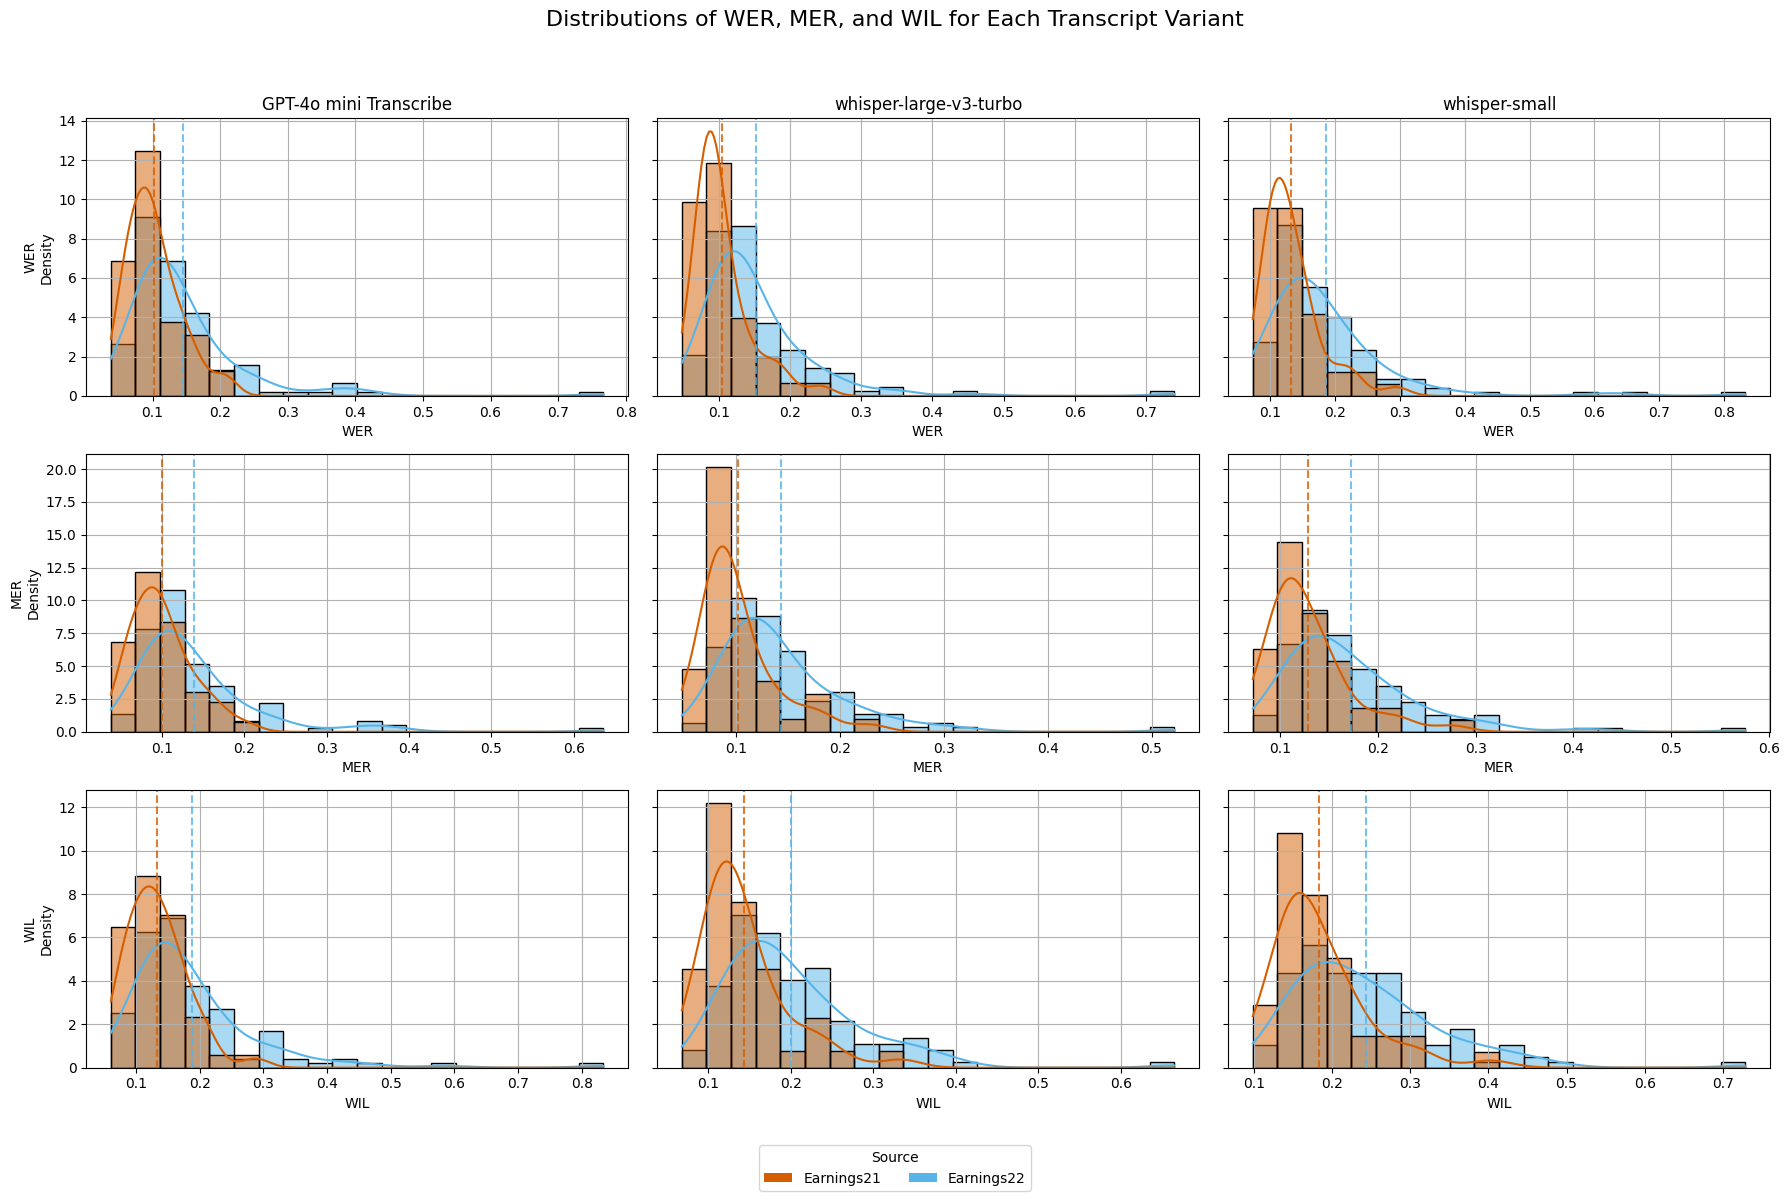

In [28]:
# Add 'source' column and combine
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'
df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Melt for boxplot
df_melted = df_combined.melt(
    id_vars=['folder', 'source', 'variant'],
    value_vars=['wer', 'mer', 'wil'],
    var_name='metric',
    value_name='value'
)

palette = {
    "combined_21": "#D55E00",
    "combined_22": "#56B4E9"
}

legend_label_map = {
    "combined_21": "Earnings21",
    "combined_22": "Earnings22"
}

variants = sorted(df_combined['variant'].unique())
metrics = ['wer', 'mer', 'wil']

# === Combined 3x3 figure ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey='row')

for row, metric in enumerate(metrics):
    print(f"\n=== {metric.upper()} Means by Variant and Source ===")

    for col, variant in enumerate(variants):
        ax = axes[row][col]
        df_variant = df_combined[df_combined['variant'] == variant]

        # Histogram with KDE
        sns.histplot(
            data=df_variant,
            x=metric,
            hue='source',
            palette=palette,
            kde=True,
            bins=20,
            stat='density',
            common_norm=False,
            ax=ax,
            legend=False
        )

        # Add vertical mean lines and print
        for source in df_variant['source'].unique():
            source_df = df_variant[df_variant['source'] == source]
            mean_val = source_df[metric].mean()
            color = palette[source]

            # Print to console
            print(f"{variant:30} | {legend_label_map[source]:12} → Mean {metric.upper()}: {mean_val:.3f}")

            ax.axvline(mean_val, linestyle='--', color=color, linewidth=1.5, alpha=0.8)

        # Titles and labels
        if row == 0:
            ax.set_title(f"{variant}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{metric.upper()}\nDensity", fontsize=10)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(metric.upper())
        ax.grid(True)

# === Add shared legend with renamed labels ===
legend_elements = [
    Patch(facecolor=palette["combined_21"], label="Earnings21"),
    Patch(facecolor=palette["combined_22"], label="Earnings22")
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.01),
    frameon=True,
    title="Source"
)

fig.suptitle("Distributions of WER, MER, and WIL for Each Transcript Variant", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

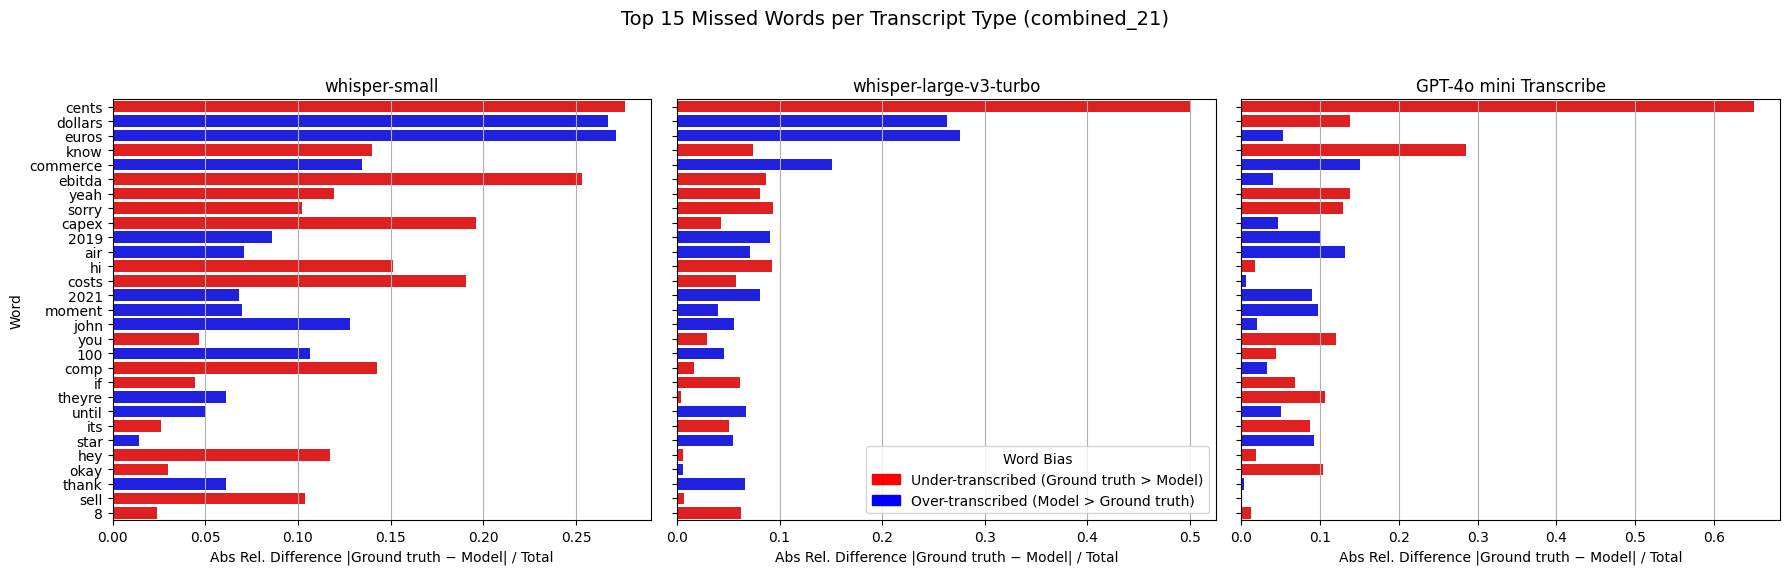

C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\welin\AppData\Local\Temp\ipykernel_2860\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

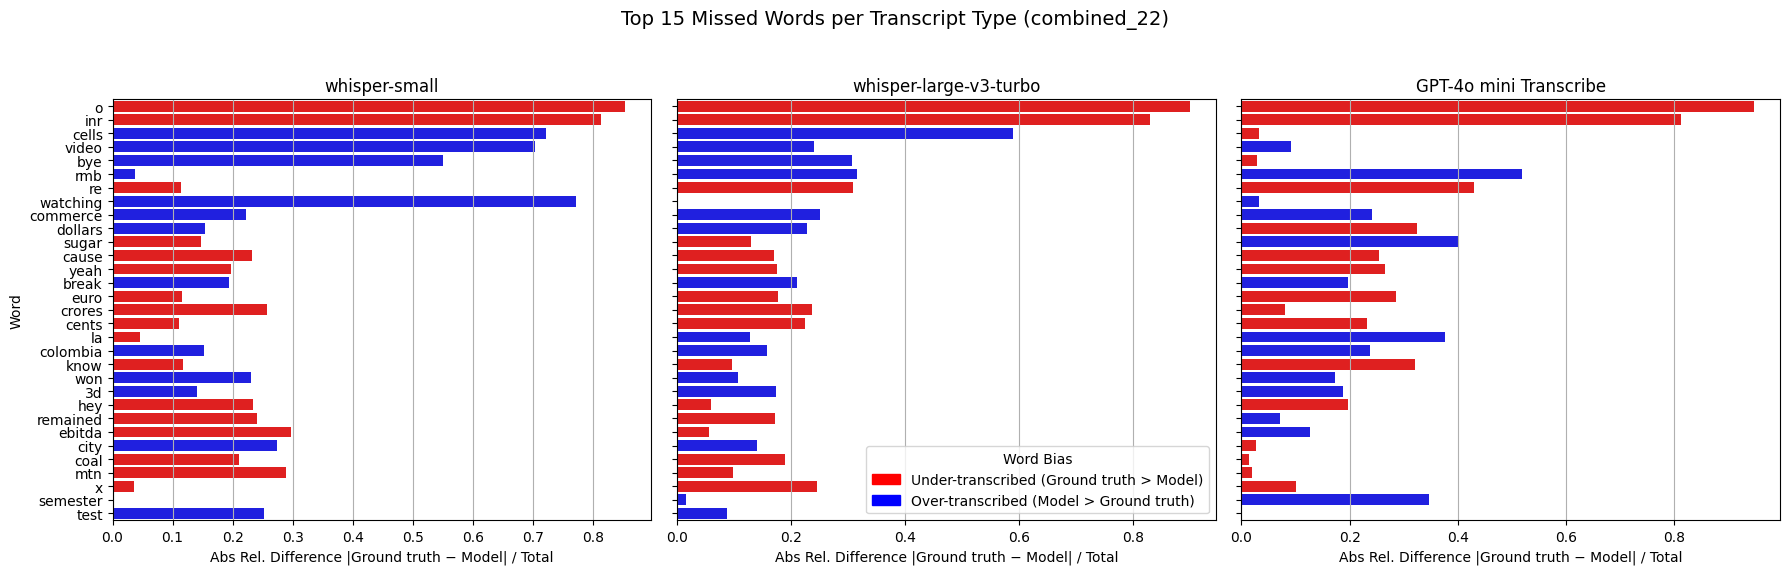

In [29]:
min_total = 100
def get_top_missed_words_by_variant(df_paths, label='', top_n=15, plot=True, filter_words=None):
    variants = df_paths['variant'].unique()
    fig, axes = plt.subplots(1, len(variants), figsize=(6 * len(variants), 6), sharey=True) if plot else (None, [None] * len(variants))
    if len(variants) == 1:
        axes = [axes]  

    all_top_words = []
    for i, (ax, variant) in enumerate(zip(axes, variants)):
        df_var = df_paths[df_paths['variant'] == variant]
        gt_words = []
        hyp_words = []

        for _, row in df_var.iterrows():
            gt_words += row['gt_text'].split()
            hyp_words += row['hyp_text'].split()

        gt_counter = Counter(gt_words)
        hyp_counter = Counter(hyp_words)
        all_words = set(gt_counter) | set(hyp_counter)

        data = []
        for word in all_words:
            gt_count = gt_counter[word]
            hyp_count = hyp_counter[word]
            total = gt_count + hyp_count
            color = 'red' if gt_count > hyp_count else 'blue'
            rel_diff = abs((gt_count - hyp_count)) / total
            data.append({
                'variant': variant,
                'word': word,
                'gt_count': gt_count,
                'hyp_count': hyp_count,
                'rel_diff': rel_diff,
                'total': total,
                'top' : False,
                'color': color
            })

        df_diff = pd.DataFrame(data)
        df_top = df_diff[df_diff['total'] > min_total].sort_values(by='rel_diff', ascending=False).head(top_n)
        df_diff['top'] = df_diff['word'].isin(df_top['word'])
        all_top_words.append(df_diff)
        if plot:
            if filter_words is not None:
                df_plot = df_diff[df_diff['word'].isin(filter_words)]
            else:
                df_plot = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)
            sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
            if i == 1:  # Only show legend on the middle plot
                legend_handles = [Patch(color='red', label='Under-transcribed (Ground truth > Model)'), Patch(color='blue', label='Over-transcribed (Model > Ground truth)')]
                ax.legend(handles=legend_handles, title='Word Bias', loc='lower right')
            ax.set_title(f"{variant}")
            ax.set_xlabel("Abs Rel. Difference |Ground truth − Model| / Total")
            ax.set_ylabel("Word")
            ax.grid(True, axis='x')

    if plot:
        plt.suptitle(f"Top {top_n} Missed Words per Transcript Type ({label})", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    return pd.concat(all_top_words, ignore_index=True)




# First run: collect all data (no plots)
df_all_21 = get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=False)
df_all_22 = get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=False)

top_words_21 = df_all_21[(df_all_21['total'] > min_total) & (df_all_21['top'])]['word'].unique()
top_words_22 = df_all_22[(df_all_22['total'] > min_total) & (df_all_22['top'])]['word'].unique()

ordered_words_21 = (
    df_all_21[df_all_21['word'].isin(top_words_21)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_22 = (
    df_all_22[df_all_22['word'].isin(top_words_22)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_21 = ordered_words_21['word'].tolist()
ordered_words_22 = ordered_words_22['word'].tolist()

get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=True, filter_words=ordered_words_21)
get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=True, filter_words=ordered_words_22)


In [30]:
import re
from difflib import SequenceMatcher

# --- Financial keyword set ---
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

def normalize_number(n):
    return str(float(n)) if '.' in n else str(int(n))

def extract_contextual_numbers(text, window=10):
    words = text.lower().split()
    numbers = []
    for idx, word in enumerate(words):
        if re.fullmatch(r'\d+(?:\.\d+)?', word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                numbers.append(normalize_number(word))
    return numbers

def count_aligned_numbers(gt_numbers, hyp_numbers):
    matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
    return sum(block.size for block in matcher.get_matching_blocks() if block.size > 0)

def evaluate_number_accuracy(df_paths):
    results = []
    variants = df_paths['variant'].unique()

    for variant in variants:
        df_var = df_paths[df_paths['variant'] == variant]

        gt_total = 0
        pred_total = 0
        correct_total = 0

        for _, row in df_var.iterrows():
            gt_numbers = extract_contextual_numbers(row['gt_text'])
            hyp_numbers = extract_contextual_numbers(row['hyp_text'])
            gt_total += len(gt_numbers)
            pred_total += len(hyp_numbers)
            correct_total += count_aligned_numbers(gt_numbers, hyp_numbers)

        precision = correct_total / pred_total if pred_total else 0
        recall = correct_total / gt_total if gt_total else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

        results.append({
            'variant': variant,
            'gt_total': gt_total,
            'pred_total': pred_total,
            'correct': correct_total,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    # Overall totals
    totals = pd.DataFrame(results).sum(numeric_only=True)
    total_correct = totals['correct']
    total_pred = totals['pred_total']
    total_gt = totals['gt_total']
    total_precision = total_correct / total_pred if total_pred else 0
    total_recall = total_correct / total_gt if total_gt else 0
    total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall) if (total_precision + total_recall) else 0

    results.append({
        'variant': 'TOTAL',
        'gt_total': total_gt,
        'pred_total': total_pred,
        'correct': total_correct,
        'precision': total_precision,
        'recall': total_recall,
        'f1': total_f1
    })
    

    df_result = pd.DataFrame(results)
    print(df_result.to_string(index=False, float_format='%.3f'))
    return df_result

# Run for each dataset
print("Number accuracy for combined_21:")
evaluate_number_accuracy(df_paths_21)
print("\nNumber accuracy for combined_22:")
evaluate_number_accuracy(df_paths_22)


Number accuracy for combined_21:
               variant  gt_total  pred_total  correct  precision  recall    f1
         whisper-small  3194.000    3183.000 2748.000      0.863   0.860 0.862
whisper-large-v3-turbo  3194.000    3240.000 2850.000      0.880   0.892 0.886
GPT-4o mini Transcribe  3194.000    3266.000 2896.000      0.887   0.907 0.897
                 TOTAL  9582.000    9689.000 8494.000      0.877   0.886 0.882

Number accuracy for combined_22:
               variant  gt_total  pred_total   correct  precision  recall    f1
         whisper-small  9514.000    9174.000  7643.000      0.833   0.803 0.818
whisper-large-v3-turbo  9514.000    9360.000  8014.000      0.856   0.842 0.849
GPT-4o mini Transcribe  9514.000    9489.000  8202.000      0.864   0.862 0.863
                 TOTAL 28542.000   28023.000 23859.000      0.851   0.836 0.844


,variant,gt_total,pred_total,correct,precision,recall,f1
0,whisper-small,9514.0,9174.0,7643.0,0.833115,0.803342,0.817958
1,whisper-large-v3-turbo,9514.0,9360.0,8014.0,0.856197,0.842338,0.849211
2,GPT-4o mini Transcribe,9514.0,9489.0,8202.0,0.864369,0.862098,0.863232
3,TOTAL,28542.0,28023.0,23859.0,0.851408,0.835926,0.843596


In [31]:
#Quick fix: adding the num error to df_22


# --- Financial keyword setup ---
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

def extract_contextual_numbers(text, window=10):
    words = text.lower().split()
    numbers = []
    for idx, word in enumerate(words):
        if re.fullmatch(r'\d+(?:\.\d+)?', word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                numbers.append(word)
    return numbers

def normalize_number(n):
    return str(float(n)).rstrip('0').rstrip('.') if '.' in n else str(int(n))

def count_aligned_numbers(gt_numbers, hyp_numbers):
    matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
    return sum(block.size for block in matcher.get_matching_blocks() if block.size > 0)

# --- Compute per-row numerical error ---
numerical_errors = []

for _, row in df_paths_22.iterrows():
    gt_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['gt_text'])]
    hyp_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['hyp_text'])]

    gt_total = len(gt_numbers)
    pred_total = len(hyp_numbers)
    correct = count_aligned_numbers(gt_numbers, hyp_numbers)

    precision = correct / pred_total if pred_total else 0
    recall = correct / gt_total if gt_total else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    numerical_errors.append({
        "folder": row["folder"],
        "variant": row["variant"],
        "numerical_error": 1 - f1
    })

# --- Merge result into df_22 ---
df_num_error = pd.DataFrame(numerical_errors)
df_22 = df_22.merge(df_num_error, on=["folder", "variant"], how="left")


In [32]:
from difflib import SequenceMatcher
import re
import pandas as pd

# Make sure high-WER flag is set
df_22['high_wer'] = df_22['wer'] > 0.4

# Filter for high-WER rows
high_wer_files = df_22[df_22['high_wer'] == True][['folder', 'variant', 'wer', 'numerical_error']].drop_duplicates()

# Merge with transcripts
df_merged = high_wer_files.merge(
    df_paths_22[['folder', 'variant', 'gt_text', 'hyp_text']],
    on=['folder', 'variant'],
    how='inner'
)

# --- Alignment Errors ---
def classify_alignment_errors(gt_words, hyp_words):
    matcher = SequenceMatcher(None, gt_words, hyp_words)
    errors = {'deletion': 0, 'insertion': 0, 'substitution': 0}
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            errors['substitution'] += max(i2 - i1, j2 - j1)
        elif tag == 'delete':
            errors['deletion'] += i2 - i1
        elif tag == 'insert':
            errors['insertion'] += j2 - j1
    return errors

# --- Number Extraction and Normalization ---
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

def extract_contextual_numbers(text, window=10):
    words = text.lower().split()
    numbers = []
    for idx, word in enumerate(words):
        if re.fullmatch(r'\d+(?:\.\d+)?', word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                numbers.append(word)
    return numbers

def normalize_number(n):
    return str(float(n)).rstrip('0').rstrip('.') if '.' in n else str(int(n))

# --- Print Report ---
print("\nError stats for files with WER > 40%:\n")
for _, row in df_merged.iterrows():
    gt_words = row['gt_text'].split()
    hyp_words = row['hyp_text'].split()
    total_words = len(gt_words)

    errs = classify_alignment_errors(gt_words, hyp_words)
    wer_calc = (errs['deletion'] + errs['insertion'] + errs['substitution']) / total_words if total_words > 0 else 0

    # Extract normalized financial numbers
    gt_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['gt_text'])]
    hyp_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['hyp_text'])]

    print(f"Folder: {row['folder']}, Variant: {row['variant']}")
    print(f"  WER (recomputed): {wer_calc:.2%}")
    print(f"  WER (from df_22): {row['wer']:.2%}")
    print(f"  Insertions: {errs['insertion']}, Deletions: {errs['deletion']}, Substitutions: {errs['substitution']}")
    print(f"  Numeric error: {row['numerical_error']:.2%}")




Error stats for files with WER > 40%:

Folder: 4351517, Variant: GPT-4o mini Transcribe
  WER (recomputed): 44.91%
  WER (from df_22): 42.17%
  Insertions: 620, Deletions: 202, Substitutions: 1689
  Numeric error: 26.98%
Folder: 4453076, Variant: whisper-small
  WER (recomputed): 106.98%
  WER (from df_22): 83.29%
  Insertions: 1045, Deletions: 255, Substitutions: 3943
  Numeric error: 66.67%
Folder: 4453076, Variant: whisper-large-v3-turbo
  WER (recomputed): 87.84%
  WER (from df_22): 73.98%
  Insertions: 987, Deletions: 252, Substitutions: 3066
  Numeric error: 47.62%
Folder: 4453076, Variant: GPT-4o mini Transcribe
  WER (recomputed): 106.65%
  WER (from df_22): 76.68%
  Insertions: 859, Deletions: 204, Substitutions: 4164
  Numeric error: 38.27%
Folder: 4463693, Variant: whisper-small
  WER (recomputed): 75.45%
  WER (from df_22): 64.89%
  Insertions: 2430, Deletions: 81, Substitutions: 1648
  Numeric error: 24.14%
Folder: 4481766, Variant: whisper-small
  WER (recomputed): 62.50

In [15]:
print(df_22.columns)

Index(['folder', 'variant', 'wer', 'mer', 'wil', 'Ticker Symbol',
       'Country by Ticker', 'UN Defined', 'Major Dialect Family',
       'Language Family', 'File Length (seconds)', 'Sampling Rate (Hz)',
       'gt_path', 'hyp_path', 'gt_word_count', 'gt_filler_count',
       'gt_word_count_clean', 'hyp_word_count', 'hyp_filler_count',
       'hyp_word_count_clean', 'gt_text', 'hyp_text', 'source',
       'numerical_error', 'high_wer'],
      dtype='object')


In [16]:
print(df_paths_22.columns)

Index(['folder', 'variant', 'gt_path', 'hyp_path', 'gt_word_count',
       'gt_filler_count', 'gt_word_count_clean', 'hyp_word_count',
       'hyp_filler_count', 'hyp_word_count_clean', 'gt_text', 'hyp_text'],
      dtype='object')


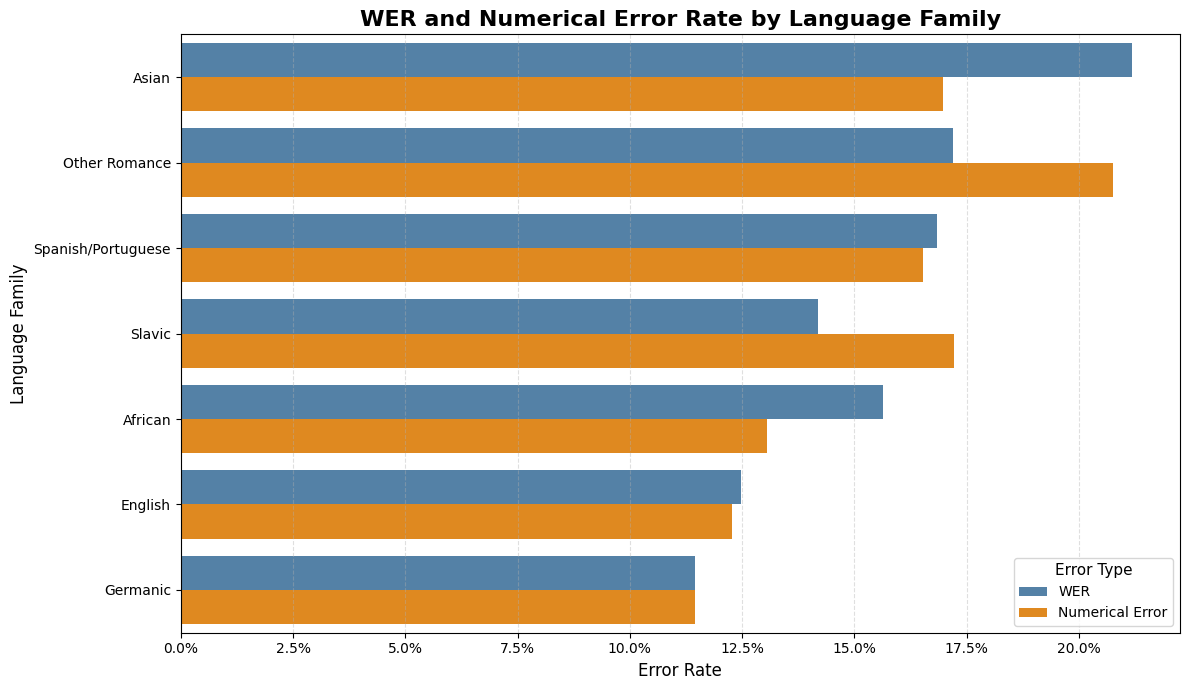

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Fix legend label capitalization
df_long["Error Type"] = df_long["Error Type"].replace({"wer": "WER"})

# Sort language families by average error
sort_order = (
    df_long.groupby("Language Family")["Error Rate"]
    .mean()
    .sort_values(ascending=False)
    .index
)

# Create the plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=df_long,
    x="Error Rate",
    y="Language Family",
    hue="Error Type",
    order=sort_order,
    palette={"WER": "steelblue", "Numerical Error": "darkorange"}
)


# Set axis labels and title
plt.title("WER and Numerical Error Rate by Language Family", fontsize=16, weight='bold')
plt.xlabel("Error Rate", fontsize=12)
plt.ylabel("Language Family", fontsize=12)

# Format x-axis as percent
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Tweak legend
plt.legend(title="Error Type", title_fontsize=11, fontsize=10)
plt.tight_layout()
plt.show()


3 assumptions:

1. The responses for each factor level have a normal population distribution (Shapiro-Wilk test)
2. These distributions have the same variance. (Levene's test )
3. The data are independent. (Some calls are from the same company, are they independant?)


Use Friedman Test in SPSS Statistics

or

Kruskal-Wallis H test H (Here there is also independence being assumed.)


In [21]:
print(df_22.head(10))

                                              folder                 variant  \
0  2020-03-0230487MTN-Ghana-2019-Annual-Results-Call           whisper-small   
1  2020-03-0230487MTN-Ghana-2019-Annual-Results-Call  whisper-large-v3-turbo   
2  2020-03-0230487MTN-Ghana-2019-Annual-Results-Call  GPT-4o mini Transcribe   
3                 2020-Annual-Results-Call-Recording           whisper-small   
4                 2020-Annual-Results-Call-Recording  whisper-large-v3-turbo   
5                 2020-Annual-Results-Call-Recording  GPT-4o mini Transcribe   
6                                            4329526           whisper-small   
7                                            4329526  whisper-large-v3-turbo   
8                                            4329526  GPT-4o mini Transcribe   
9                                            4351517           whisper-small   

        wer       mer       wil ticker_symbol Country by Ticker  \
0  0.195067  0.187002  0.269813         MTNGH       


📊 Kruskal-Wallis tests for model: whisper-small
  📈 WER: Statistic = 22.596, p-value = 0.0009


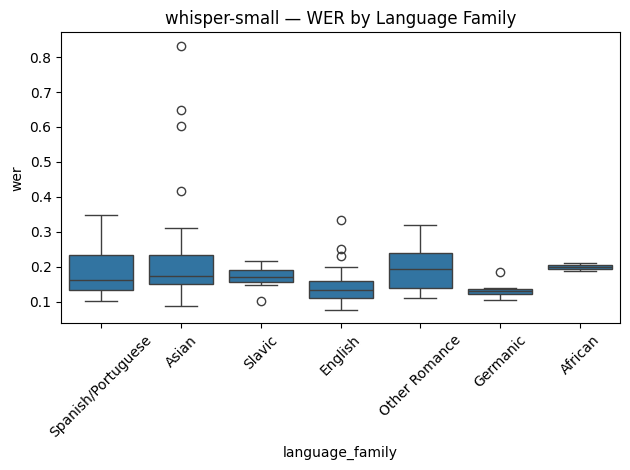

  🧮 Numerical Error: Statistic = 14.771, p-value = 0.0221


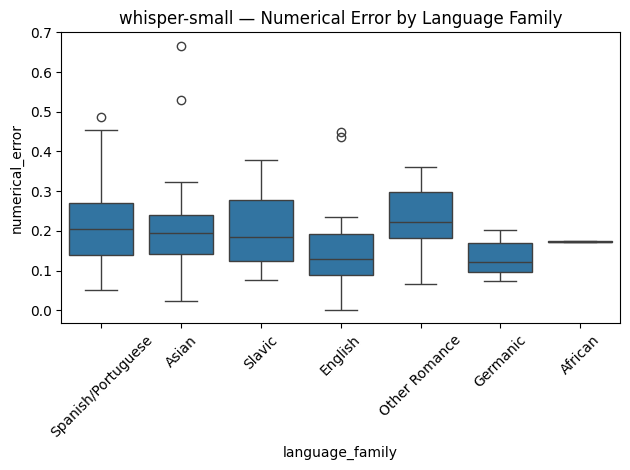


📊 Kruskal-Wallis tests for model: whisper-large-v3-turbo
  📈 WER: Statistic = 26.155, p-value = 0.0002


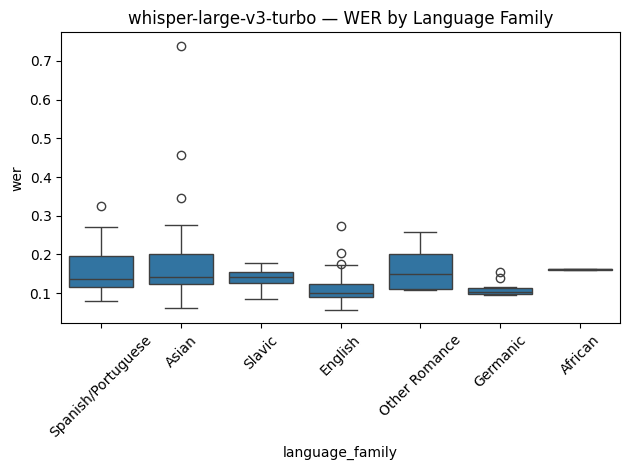

  🧮 Numerical Error: Statistic = 12.623, p-value = 0.0494


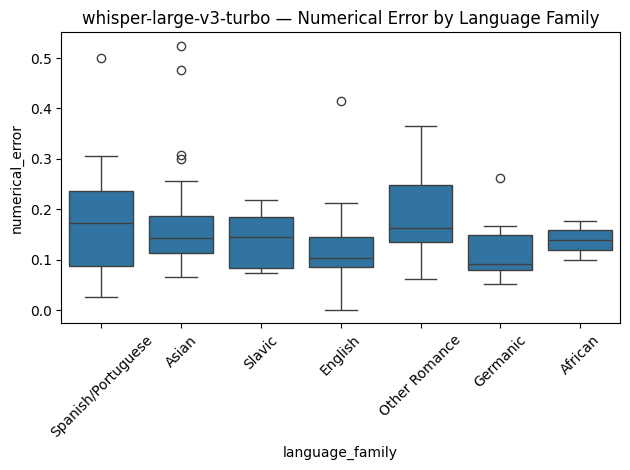


📊 Kruskal-Wallis tests for model: GPT-4o mini Transcribe
  📈 WER: Statistic = 14.460, p-value = 0.0249


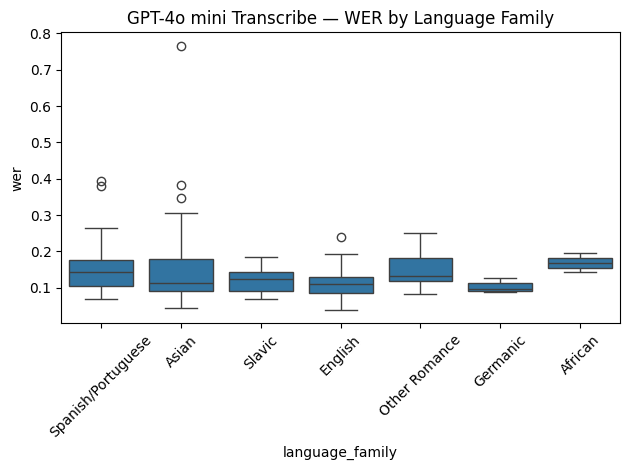

  🧮 Numerical Error: Statistic = 11.036, p-value = 0.0873


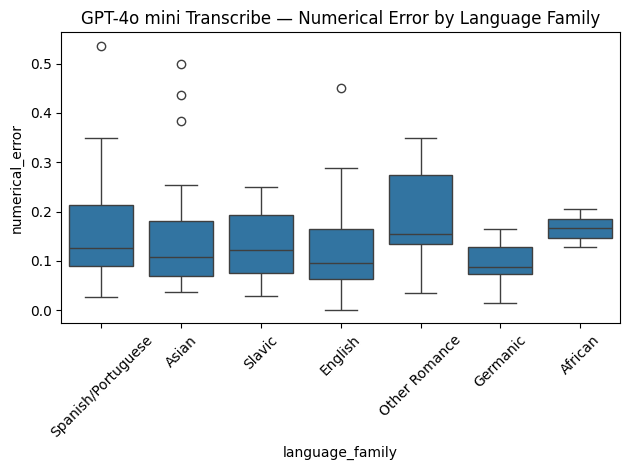

In [ ]:
from scipy.stats import kruskal
import seaborn as sns
import matplotlib.pyplot as plt

# Rename for consistency
df_22 = df_22.rename(columns={
    "Language Family": "language_family",
    "Ticker Symbol": "ticker_symbol"
})

# Drop rows with missing values
df_22 = df_22.dropna(subset=["language_family", "ticker_symbol", "variant", "wer", "numerical_error"])

# Sample one folder per ticker (ensuring independence)
sampled_folders = (
    df_22.groupby("ticker_symbol")["folder"]
    .apply(lambda x: x.sample(n=1, random_state=42))
    .reset_index(drop=True)
)

# Keep all models for selected folders
df_one_call_per_ticker = df_22[df_22["folder"].isin(sampled_folders)]

# Run Kruskal-Wallis tests
for variant in df_one_call_per_ticker["variant"].unique():
    print(f"\n📊 Kruskal-Wallis tests for model: {variant}")

    df_variant = df_one_call_per_ticker[df_one_call_per_ticker["variant"] == variant]

    # ---- WER ----
    grouped_wer = [group["wer"].values for _, group in df_variant.groupby("language_family")]
    if len(grouped_wer) >= 2:
        stat, p = kruskal(*grouped_wer)
        print(f"  📈 WER: Statistic = {stat:.3f}, p-value = {p:.4f}")
        sns.boxplot(data=df_variant, x="language_family", y="wer")
        plt.title(f"{variant} — WER by Language Family")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("  ⚠️ Not enough language families with WER to compare.")

    # ---- Numerical Error ----
    grouped_num = [group["numerical_error"].values for _, group in df_variant.groupby("language_family")]
    if len(grouped_num) >= 2:
        stat, p = kruskal(*grouped_num)
        print(f"  🧮 Numerical Error: Statistic = {stat:.3f}, p-value = {p:.4f}")
        sns.boxplot(data=df_variant, x="language_family", y="numerical_error")
        plt.title(f"{variant} — Numerical Error by Language Family")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("  ⚠️ Not enough language families with numerical error to compare.")


In [22]:
print(df_one_call_per_ticker.head(10))

    folder                 variant       wer       mer       wil  \
0  4484942           whisper-small  0.185654  0.179521  0.266249   
1  4468000  whisper-large-v3-turbo  0.258641  0.239234  0.340131   
2  4453225           whisper-small  0.198623  0.192510  0.275080   
3  4483680  whisper-large-v3-turbo  0.087137  0.085787  0.113371   
4  4450779           whisper-small  0.161518  0.154829  0.228236   
5  4475604  whisper-large-v3-turbo  0.055929  0.055033  0.084526   
6  4468647  whisper-large-v3-turbo  0.201211  0.194245  0.251777   
7  4483668  GPT-4o mini Transcribe  0.101330  0.100387  0.127890   
8  4482641           whisper-small  0.157671  0.150940  0.231191   
9  4448760  GPT-4o mini Transcribe  0.070782  0.070275  0.091997   

  ticker_symbol Country by Ticker                      UN Defined  \
0         AIAGF           Germany     Europe and Northern America   
1         ALSMY            France     Europe and Northern America   
2         APNHF      South Africa           

In [54]:
# Count how many times each Ticker Symbol appears
ticker_counts = df_22["Ticker Symbol"].value_counts()

# Show how many tickers appear more than once
num_repeated_tickers = (ticker_counts > 1).sum()
print(f"Number of tickers with more than one file: {num_repeated_tickers}")

# Optionally: preview top 10 most repeated tickers
print("\nTop repeated tickers:")
print(ticker_counts.head(10))
print("Unique tickers:", len(ticker_counts))

Number of tickers with more than one file: 114

Top repeated tickers:
MTNGH    12
TLK       9
OTGLF     9
HEPS      6
SOSSF     6
KGHPF     6
LVMHF     3
GLOP      3
SARTF     3
BNDSF     3
Name: Ticker Symbol, dtype: int64
Unique tickers: 114


**LONG RUNNING TIME BLOCKS**

Making lists of examples:

In [ ]:
import pandas as pd
import random
import re
from collections import defaultdict
from rapidfuzz import process, fuzz

# Seed for reproducibility
random.seed(42)

# Combine top word lists
top_words = list(set(ordered_words_21 + ordered_words_22))

# Parameters
chunk_size = 20
window_range = 300
sample_limit = 30

# Store results
context_examples = {word: [] for word in top_words}

datasets = [("combined_21", df_paths_21), ("combined_22", df_paths_22)]

for label, df_paths in datasets:
    for _, row in df_paths.iterrows():
        gt_text = row['gt_text'].lower()
        whisper_text = row['hyp_text'].lower()  # Assuming this column is the model output

        gt_words = re.findall(r'\b\w+\b', gt_text)
        whisper_words = re.findall(r'\b\w+\b', whisper_text)

        whisper_snippets = [
            ' '.join(whisper_words[i:i + chunk_size])
            for i in range(len(whisper_words) - chunk_size + 1)
        ]

        # Index locations of top words in GT
        word_indices = defaultdict(list)
        for i, token in enumerate(gt_words):
            if token in top_words:
                word_indices[token].append(i)

        for token, indices in word_indices.items():
            sampled_indices = random.sample(indices, min(sample_limit, len(indices)))
            for i in sampled_indices:
                start = max(i - 10, 0)
                end = min(i + 11, len(gt_words))
                gt_snippet = ' '.join(gt_words[start:end])

                # Estimate where to look in hypothesis
                approx_chunk = int(i * len(whisper_snippets) / len(gt_words))
                chunk_start = max(approx_chunk - window_range, 0)
                chunk_end = min(approx_chunk + window_range + 1, len(whisper_snippets))
                local_snippets = whisper_snippets[chunk_start:chunk_end]

                best_match, score, _ = process.extractOne(
                    gt_snippet, local_snippets, scorer=fuzz.partial_ratio
                )

                whisper_match = best_match if best_match else '[No match found]'
                whisper_start_index = (
                    chunk_start + local_snippets.index(best_match)
                    if best_match in local_snippets else -1
                )

                context_examples[token].append({
                    'word': token,
                    'gt_snippet': gt_snippet,
                    'gt_index': i,
                    'whisper_snippet': whisper_match,
                    'whisper_index': whisper_start_index,
                    'score': score,
                    'dataset': label,
                    'folder': row['folder']
                })

# Flatten and save as CSV
rows = [example for word_examples in context_examples.values() for example in word_examples]
df_context = pd.DataFrame(rows)
df_context.to_csv('top_word_context_examples.csv', index=False)
print(f"Saved {len(df_context)} examples to 'top_word_context_examples.csv'")


NameError: name 'ordered_words_21' is not defined

In [ ]:
rows = []

for word, examples in context_examples.items():
    for ex in examples:
        rows.append({
            "word": word,
            "gt_snippet": ex['gt_snippet'],
            "whisper_snippet": ex['whisper_snippet'],
            "gt_index": ex['gt_index'],
            "whisper_index": ex['whisper_index'],
            "score": ex['score'],
            "folder": ex['folder'],
            "dataset": ex['dataset']
        })

df_matches = pd.DataFrame(rows)
df_matches.to_csv("gt_whisper_matches.csv", index=False)


Number exploration

In [13]:
import pandas as pd
import random
import re
from collections import defaultdict
from rapidfuzz import process, fuzz

# Reproducibility
random.seed(42)

# Parameters
chunk_size = 20
window_range = 300
sample_limit = 30
score_threshold = 70  # Only include matches with score ≥ 70

# Pattern for detecting numbers
number_pattern = r'\d+(?:\.\d+)?'

# Where to store results
examples = {
    'not_transcribed_as_number': [],
    'incorrect_number_transcription': []
}

# Loop through datasets
datasets = [("combined_21", df_paths_21), ("combined_22", df_paths_22)]

for label, df_paths in datasets:
    for _, row in df_paths.iterrows():
        gt_text = row['gt_text']
        hyp_text = row['hyp_text']
        variant = row['variant']

        token_pattern = r'\d+\.\d+|\w+'
        gt_words = re.findall(token_pattern, gt_text)
        hyp_words = re.findall(token_pattern, hyp_text)

        # Create rolling hypothesis snippets
        hyp_snippets = [
            ' '.join(hyp_words[i:i + chunk_size])
            for i in range(len(hyp_words) - chunk_size + 1)
        ]

        # Find all numbers in GT and their positions
        gt_number_indices = [(i, word) for i, word in enumerate(gt_words) if re.fullmatch(number_pattern, word)]

        # Sample some numbers for inspection
        sampled = random.sample(gt_number_indices, min(sample_limit, len(gt_number_indices)))

        for i, number in sampled:
            # Get GT context
            start = max(i - 10, 0)
            end = min(i + 11, len(gt_words))
            gt_snippet = ' '.join(gt_words[start:end])

            # Approximate matching region in hypothesis
            approx_chunk = int(i * len(hyp_snippets) / len(gt_words))
            chunk_start = max(approx_chunk - window_range, 0)
            chunk_end = min(approx_chunk + window_range + 1, len(hyp_snippets))
            local_snippets = hyp_snippets[chunk_start:chunk_end]

            # Fuzzy match
            best_match, score, _ = process.extractOne(gt_snippet, local_snippets, scorer=fuzz.partial_ratio)
            hyp_snippet = best_match if best_match else '[No match found]'

            if best_match and score >= score_threshold:
                if not re.search(number, hyp_snippet):
                    if not re.search(r'\d', hyp_snippet):
                        # Case (a): number not transcribed at all
                        examples['not_transcribed_as_number'].append({
                            'number': number,
                            'gt_snippet': gt_snippet,
                            'whisper_snippet': hyp_snippet,
                            'type': 'missing',
                            'variant': variant,
                            'score': score,
                            'dataset': label,
                            'folder': row['folder']
                        })
                    else:
                        # Case (b): number incorrectly transcribed
                        hyp_numbers = re.findall(number_pattern, hyp_snippet)
                        if number not in hyp_numbers:
                            examples['incorrect_number_transcription'].append({
                                'number': number,
                                'gt_snippet': gt_snippet,
                                'whisper_snippet': hyp_snippet,
                                'type': 'wrong',
                                'variant': variant,
                                'score': score,
                                'dataset': label,
                                'folder': row['folder']
                            })

# Save to CSV
for error_type, data in examples.items():
    df = pd.DataFrame(data)
    filename = f'{error_type}_examples.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {len(df)} examples to '{filename}'")


Saved 179 examples to 'not_transcribed_as_number_examples.csv'
Saved 612 examples to 'incorrect_number_transcription_examples.csv'


STASH FOR STAT TEST


📊 Checking ANOVA assumptions for variant: whisper-small
Shapiro-Wilk test for Normality (WER residuals):
  Statistic: 0.765, p-value: 0.0000
Shapiro-Wilk test for Normality (Numerical Error residuals):
  Statistic: 0.924, p-value: 0.0000
Levene’s test for equal variances (WER):
  Statistic: 2.558, p-value: 0.0231
Levene’s test for equal variances (Numerical Error):
  Statistic: 1.894, p-value: 0.0875


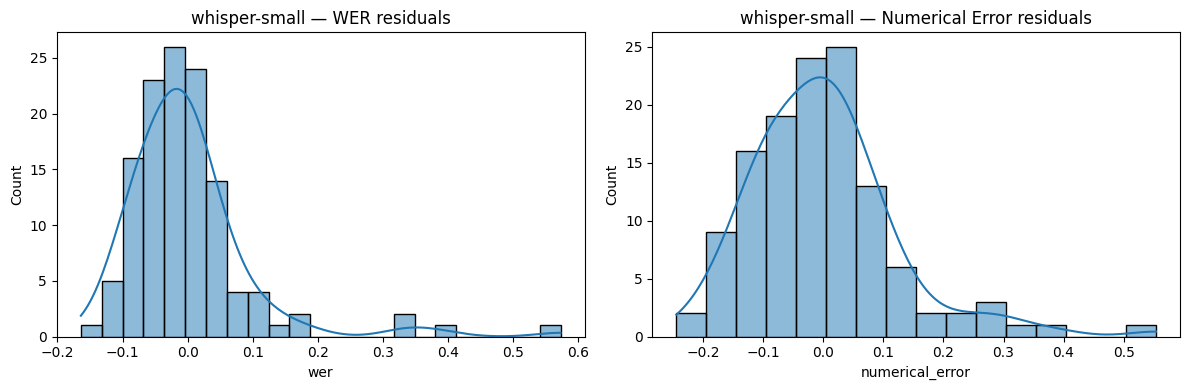


📊 Checking ANOVA assumptions for variant: whisper-large-v3-turbo
Shapiro-Wilk test for Normality (WER residuals):
  Statistic: 0.756, p-value: 0.0000
Shapiro-Wilk test for Normality (Numerical Error residuals):
  Statistic: 0.840, p-value: 0.0000
Levene’s test for equal variances (WER):
  Statistic: 2.292, p-value: 0.0397
Levene’s test for equal variances (Numerical Error):
  Statistic: 0.654, p-value: 0.6870


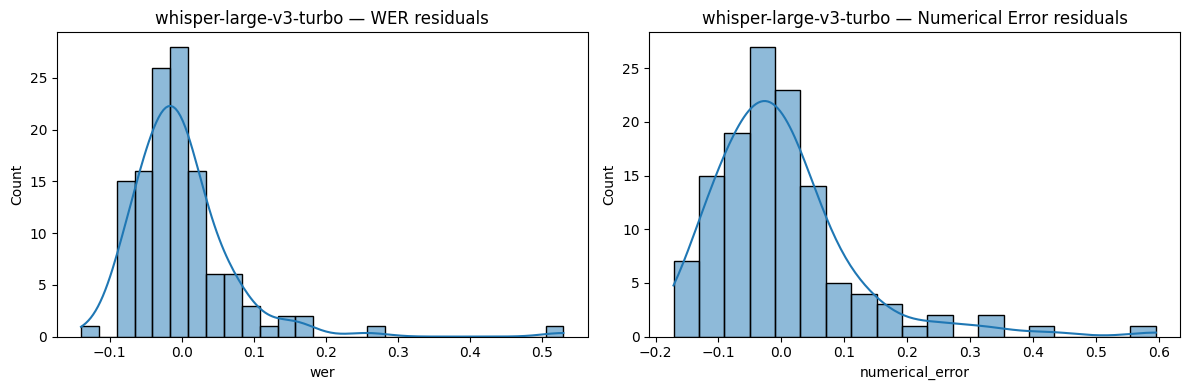


📊 Checking ANOVA assumptions for variant: GPT-4o mini Transcribe
Shapiro-Wilk test for Normality (WER residuals):
  Statistic: 0.744, p-value: 0.0000
Shapiro-Wilk test for Normality (Numerical Error residuals):
  Statistic: 0.900, p-value: 0.0000
Levene’s test for equal variances (WER):
  Statistic: 2.312, p-value: 0.0381
Levene’s test for equal variances (Numerical Error):
  Statistic: 0.708, p-value: 0.6438


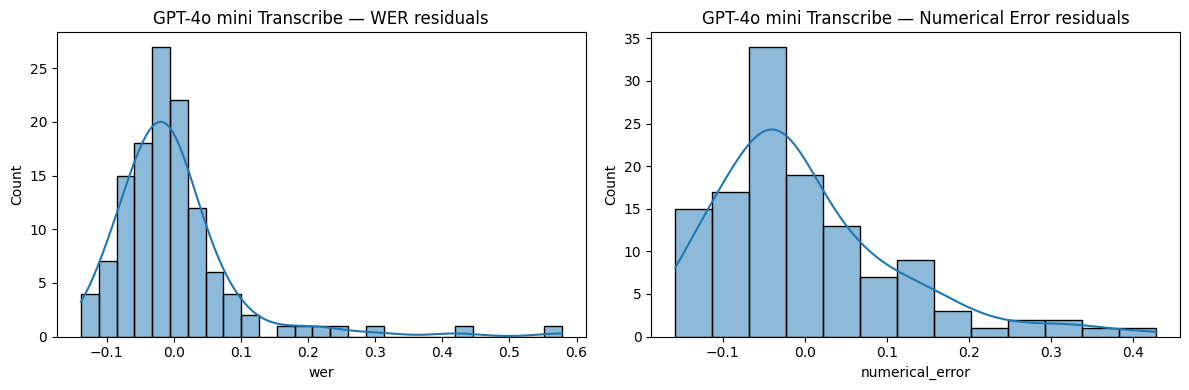

In [ ]:
#ANOVA AND WONT WORK
from scipy.stats import shapiro, levene

# Loop through each variant
for variant in df_22["variant"].unique():
    print(f"\n📊 Checking ANOVA assumptions for variant: {variant}")
    df_variant = df_22[df_22["variant"] == variant].dropna(subset=["Language Family"])
    
    # === GROUP DATA ===
    grouped_wer = [group["wer"].values for _, group in df_variant.groupby("Language Family")]
    grouped_num = [group["numerical_error"].values for _, group in df_variant.groupby("Language Family")]

    # === NORMALITY (Shapiro-Wilk test on residuals) ===
    print("Shapiro-Wilk test for Normality (WER residuals):")
    residuals_wer = df_variant["wer"] - df_variant.groupby("Language Family")["wer"].transform("mean")
    stat, p = shapiro(residuals_wer)
    print(f"  Statistic: {stat:.3f}, p-value: {p:.4f}")

    print("Shapiro-Wilk test for Normality (Numerical Error residuals):")
    residuals_num = df_variant["numerical_error"] - df_variant.groupby("Language Family")["numerical_error"].transform("mean")
    stat, p = shapiro(residuals_num)
    print(f"  Statistic: {stat:.3f}, p-value: {p:.4f}")

    # === HOMOGENEITY OF VARIANCES (Levene's test) ===
    print("Levene’s test for equal variances (WER):")
    stat, p = levene(*grouped_wer)
    print(f"  Statistic: {stat:.3f}, p-value: {p:.4f}")

    print("Levene’s test for equal variances (Numerical Error):")
    stat, p = levene(*grouped_num)
    print(f"  Statistic: {stat:.3f}, p-value: {p:.4f}")
    
    # Optional: Q-Q plots for visual inspection
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(residuals_wer, kde=True, ax=axes[0])
    axes[0].set_title(f"{variant} — WER residuals")
    sns.histplot(residuals_num, kde=True, ax=axes[1])
    axes[1].set_title(f"{variant} — Numerical Error residuals")
    plt.tight_layout()
    plt.show()
